In [4]:
import symnum
import symnum.numpy as snp
import sympy
import simsde
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import arviz
import corner
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

In [5]:
# x[0]: extended space (rough), x[1]: momentum, x[2]:position
# unit mass (M = 1) 

def drift_position(x, θ):
    return snp.array([x[1]])

def drift_momentum(x, θ):
    λ, *_ = θ
    # the potential function q -> V(q) is assumed to be V(q) = q^2 /2 
    return snp.array([- x[2] + λ*x[0]])

def diff_coeff_rough(x, θ):
    *_, α, β = θ
    σ = snp.sqrt(2*α/β)
    return snp.array([[σ]])

def drift_rough(x, θ):
    λ, α, *_ = θ
    return snp.array([- λ*x[1] - α*x[0]])

def drift_smooth(x, θ):
    return snp.concatenate((drift_momentum(x, θ), drift_position(x, θ)))

def drift_func(x, θ):
    return snp.concatenate((drift_rough(x, θ), drift_smooth(x, θ)))

def diff_coeff(x, θ):
    *_, α, β = θ
    σ = snp.sqrt(2*α/β)
    return snp.array([[σ], [0], [0]])
    
dim_x = 3
dim_s1 = 1
dim_s2 = 1
dim_r = 1
dim_θ = 3
dim_w = 1

Text(0.5, 0, 'Time')

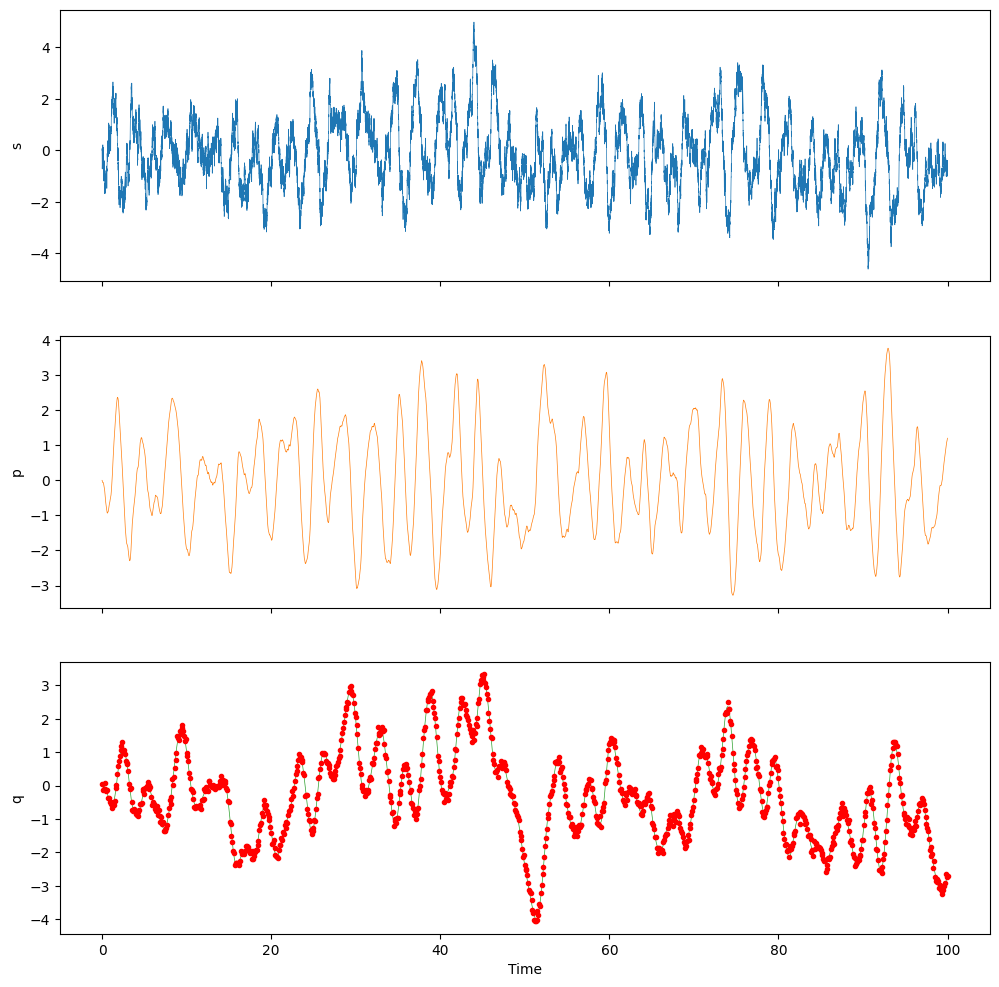

In [6]:
dim_u = 3
dim_v_0 = 1

def generate_θ(u):
    return jnp.array(
        [ 
            jnp.sqrt(2)*u[0],  # λ
            jnp.exp(u[1]),  # α
            jnp.exp(u[2]),  # β
        ]
    )
    
def generate_x_0(θ, v_0):
    return jnp.array([0.00, 0.00, 0.00])
    
def obs_func(x_seq):
    return (x_seq[:, 2])
    
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    x_0 = generate_x_0(θ, state.pos[dim_u:dim_u + dim_v_0])
    return {"λ": θ[0], "α": θ[1], "β": θ[2]}
    
def get_generate_x_seq_function(step_func, lower_bound=-500): # -500 is default

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x = jnp.clip(x, lower_bound)
            x_next = lax.select(x > lower_bound, step_func(x, θ, n, dt), x)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq

def get_posterior_density_functions(
    generate_θ, 
    generate_x_0, 
    generate_x_seq,
    obs_func,
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices, 
    y_obs
):
        
    @jit
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_u + dim_v_0], q[dim_u + dim_v_0:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_θ(u)
        x_0 = generate_x_0(θ, v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        y_mean = obs_func(x_seq[obs_time_indices])
        return (
            (((y_obs - y_mean) / obs_noise_std)**2).sum() / 2 
            + y_obs.size * jnp.log(obs_noise_std) 
            + (q **2).sum() / 2
        )
        
    @jit
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val
        
    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    }
    
step_funcs_and_dim_n = {
    "euler_maruyama": (
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
        dim_r
    ),
    "local_gaussian_ii": (
        simsde.integrators.hypoelliptic_ii_local_gaussian_step(drift_func, drift_rough, drift_position, drift_momentum, diff_coeff_rough),
        3*dim_r
    )
}

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}


dt_simulation = 1e-3
t_max = 100.
dt_observation = 0.1
t_seq_simulation = np.arange(int(t_max / dt_simulation) + 1) * dt_simulation
obs_time_indices_simulation = slice(None, None, int(dt_observation / dt_simulation))

simulation_method = "local_gaussian_ii"
#simulation_method = "euler_maruyama"

rng_obs = np.random.default_rng(20221111)
obs_noise_std = 0.1
x_0_obs = np.array([0.0, 0.0, 0.0])
θ_obs = np.array([2.0, 1.0, 0.5])
n_seq_obs = rng_obs.standard_normal(
    (t_seq_simulation.shape[0] - 1, step_funcs_and_dim_n[simulation_method][1])
)
x_seq_obs = generate_x_seq_functions[simulation_method](
    x_0_obs, 
    θ_obs, 
    n_seq_obs,
    t_seq_simulation
)
y_obs_mean = obs_func(x_seq_obs[obs_time_indices_simulation])
y_obs = y_obs_mean + obs_noise_std * rng_obs.standard_normal(y_obs_mean.shape)

fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'spq' # s: extended variable (rough component), p: momentum, q: position
for i, ax in enumerate(axes):
    ax.plot(t_seq_simulation, x_seq_obs[:, i], color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[2].plot(t_seq_simulation[obs_time_indices_simulation], y_obs, 'r.')
axes[-1].set_xlabel('Time')


euler_maruyama
0.02


Sampling stage: Adaptive warm up [13:57] > Main non-adaptive [29:03]

Chain 1/4: 100%|██████████|1000/1000 [07:21<00:00, 2.27it/s, n_step=1.02e+03, accept_stat=0.880]

Chain 2/4: 100%|██████████|1000/1000 [07:14<00:00, 2.30it/s, n_step=1.02e+03, accept_stat=0.885]

Chain 3/4: 100%|██████████|1000/1000 [07:14<00:00, 2.30it/s, n_step=1.02e+03, accept_stat=0.882]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 4/4: 100%|██████████|1000/1000 [07:13<00:00, 2.31it/s, n_step=1.02e+03, accept_stat=0.862]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,1.912,0.077,1.763,2.055,0.003,0.002,779.0,1600.0,1.0
α,1.086,0.202,0.727,1.481,0.008,0.005,728.0,1478.0,1.0
β,0.520,0.082,0.378,0.683,0.003,0.002,947.0,1779.0,1.0


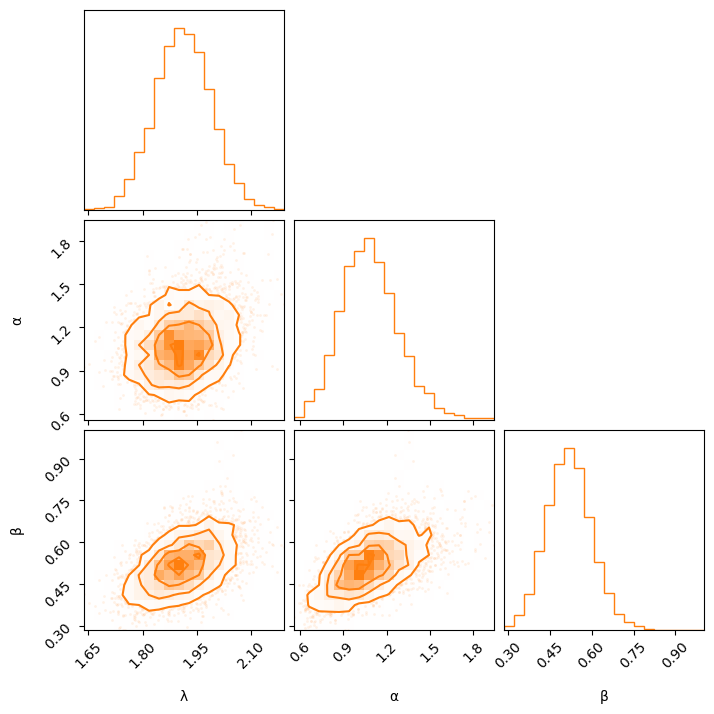

local_gaussian_ii
0.02


Sampling stage: Adaptive warm up [20:27] > Main non-adaptive [43:15]

Chain 1/4: 100%|██████████|1000/1000 [10:50<00:00, 1.54it/s, n_step=1.02e+03, accept_stat=0.867]

Chain 2/4: 100%|██████████|1000/1000 [10:49<00:00, 1.54it/s, n_step=1.02e+03, accept_stat=0.880]

Chain 3/4: 100%|██████████|1000/1000 [10:48<00:00, 1.54it/s, n_step=1.02e+03, accept_stat=0.882]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 4/4: 100%|██████████|1000/1000 [10:46<00:00, 1.55it/s, n_step=1.02e+03, accept_stat=0.873]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,1.907,0.078,1.757,2.043,0.003,0.002,934.0,1730.0,1.01
α,1.045,0.204,0.681,1.431,0.006,0.005,1040.0,1666.0,1.01
β,0.489,0.077,0.344,0.625,0.002,0.001,1365.0,1950.0,1.00


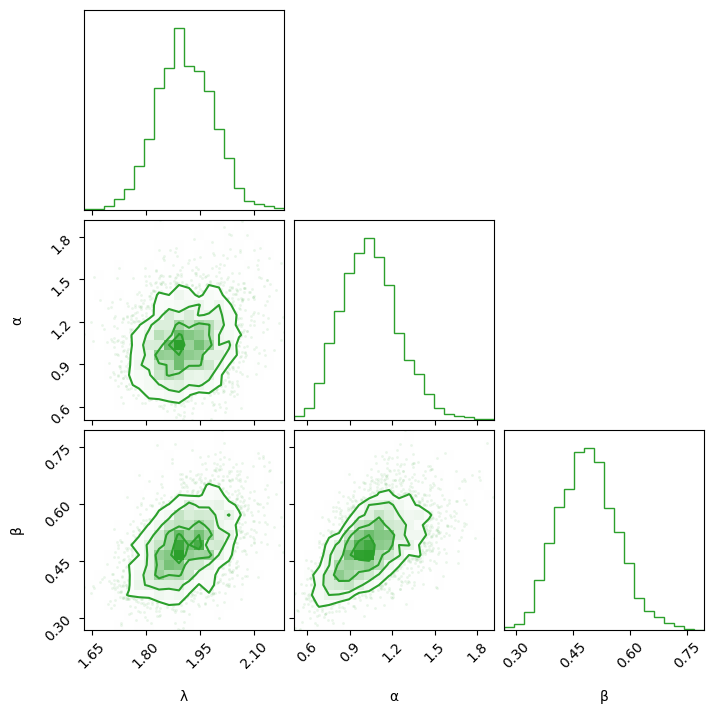

euler_maruyama
0.01


Sampling stage: Adaptive warm up [24:38] > Main non-adaptive [51:58]

Chain 1/4: 100%|██████████|1000/1000 [13:00<00:00, 1.28it/s, n_step=1.02e+03, accept_stat=0.863]

Chain 2/4: 100%|██████████|1000/1000 [13:01<00:00, 1.28it/s, n_step=1.02e+03, accept_stat=0.867]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 3/4: 100%|██████████|1000/1000 [13:00<00:00, 1.28it/s, n_step=1.02e+03, accept_stat=0.848]

Chain 4/4: 100%|██████████|1000/1000 [12:55<00:00, 1.29it/s, n_step=1.02e+03, accept_stat=0.851]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,-0.002,1.916,-2.038,2.035,0.954,0.730,6.0,144.0,1.75
α,1.059,0.203,0.702,1.460,0.006,0.004,1026.0,1802.0,1.00
β,0.497,0.076,0.362,0.643,0.002,0.001,1398.0,2081.0,1.00


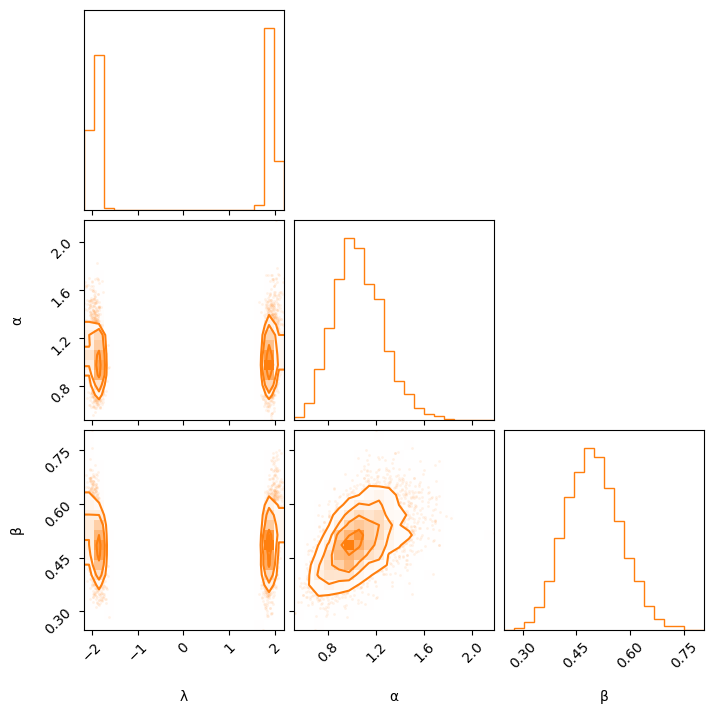

local_gaussian_ii
0.01


Sampling stage: Adaptive warm up [39:41] > Main non-adaptive [57:41]

Chain 1/4: 100%|██████████|1000/1000 [21:06<00:00, 1.27s/it, n_step=1.02e+03, accept_stat=0.866]

Chain 2/4: 100%|██████████|1000/1000 [12:43<00:00, 1.31it/s, n_step=1.02e+03, accept_stat=0.880]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 3/4: 100%|██████████|1000/1000 [11:50<00:00, 1.41it/s, n_step=1.02e+03, accept_stat=0.871]

Chain 4/4: 100%|██████████|1000/1000 [12:01<00:00, 1.39it/s, n_step=1.02e+03, accept_stat=0.876]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,1.912,0.078,1.769,2.065,0.003,0.002,974.0,1634.0,1.00
α,1.022,0.201,0.628,1.365,0.007,0.005,881.0,1828.0,1.00
β,0.482,0.077,0.346,0.637,0.003,0.002,951.0,1880.0,1.01


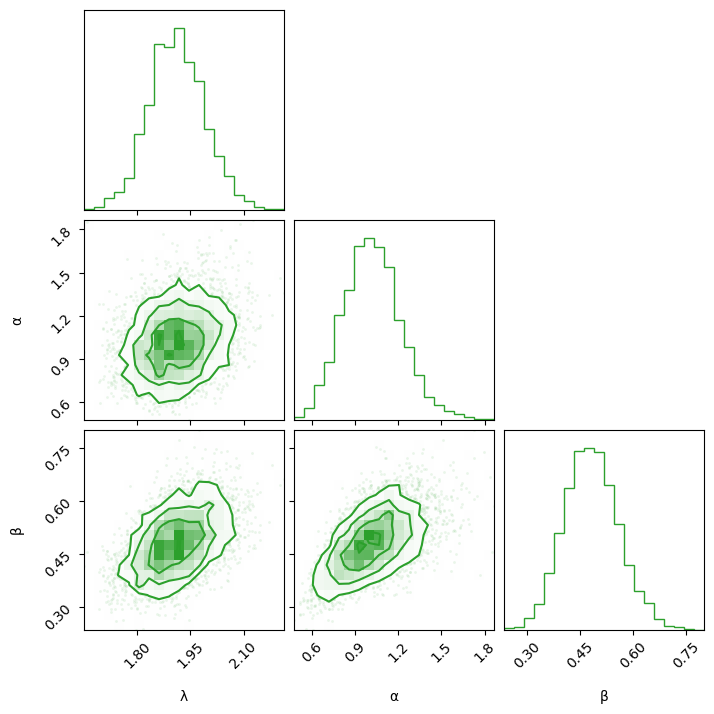

In [10]:
n_chain = 4
n_warm_up_iter = 500
n_main_iter = 1000
dt_inference_seq = np.array([0.02, 0.01]) 
trace = [[] for i in range(2)]

for dt_inference in dt_inference_seq:
    color = 1
    for key, generate_x_seq in generate_x_seq_functions.items():
        print(key)
        print(dt_inference)
        t_seq_inference = t_seq_simulation[::int(dt_inference / dt_simulation)]
        obs_time_indices = slice(0, None, int(dt_observation / dt_inference))

        common_kwargs = {
            "generate_θ": generate_θ,
            "generate_x_0": generate_x_0,
            "obs_func": obs_func,
            "t_seq": t_seq_inference,
            "dim_u": dim_u,
            "dim_v_0": dim_v_0,
            "obs_noise_std": 0.1,
            "obs_time_indices": obs_time_indices,
            "y_obs": y_obs
        }

        posterior_density_functions = get_posterior_density_functions(
            generate_x_seq=generate_x_seq, **common_kwargs
        )
        dim_q = (
            common_kwargs["dim_u"] 
            + common_kwargs["dim_v_0"]
            + step_funcs_and_dim_n[key][1] * (len(t_seq_inference) - 1)
        )
        rng = np.random.default_rng(20230227)
        system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
        integrator = mici.integrators.LeapfrogIntegrator(system)
        sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
        adapters = [
            mici.adapters.DualAveragingStepSizeAdapter(0.8),
        ]
        init_states = []
        while len(init_states) < n_chain:
            q = rng.standard_normal(dim_q)
            g, v = system._grad_neg_log_dens(q)
            if not (np.any(np.isnan(g)) or np.isnan(v)):
                init_states.append(q)
        final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
            n_warm_up_iter=n_warm_up_iter,
            n_main_iter=n_main_iter,
            init_states=init_states,
            monitor_stats=["n_step", "accept_stat"],
            trace_funcs=[trace_func],
            adapters=adapters,
        )
        summary = arviz.summary(traces)
        fig = corner.corner(traces, 
            color=f'C{color}',
        )
        display(summary)
        display(fig)
        plt.close(fig)
        trace[color-1].append(traces)
        color += 1
